# Sprint 17: Final Project - Telecom Churn Prediction

# Contents <a id='back'></a>

* [Introduction](#introduction)
* [Data Overview](#data_overview)
    * [Initialization](#initialization)
    * [Load Data](load_data)
    * [Fix Data](#fix_data)
    * [Check for Duplicates](#duplicates)
    * [Check for Missing Values](#missing_values)
* [Exploratory Data Analysis](#eda)
* [Clarifying Questions](#questions)   
* [Plan](#plan)
* [Modelling](#model)
    * [Prepare Data for Modelling](#model_prep)   
    * [Visualize Data for Modelling](#visualize)
    * [Encode Categorical Features](#encode)
    * [Model](#model)
        * [Random Forest Model](#random_forest)
        * [Gradient Boosting Model](#gradient_boosting)    
* [Solution Report](#conclusion)

# Introduction <a id='introduction'></a>

Intro: The telecom operator Interconnect would like to forecast churn of their clients
Business Problem Statement: The company wants to forecast which users are planning to leave
Business Value: TO ensure loyalty, those who are going to leave, will be offered with promotional codes

Machine learning goal: Will classify each client into one of two groups
1) loyal customers who won't churn
2) customers who will churn in the future

```python
Target feature: the `'EndDate'` column equals `'No'`.
Primary metric: AUC-ROC.
Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP
```

The data consists of files obtained from different sources:
    contract.csv - contract info
    personal.csv - the client's personal data
    internet.csv - info about internet services
    phone.csv - info about telephone services

In each file, the customerID column containes a unique code assigned to each client

Our target is the EndDate column
    Date means a day when a client has left
    No means that the client is active

# Data Overview <a id='data_overview'></a>

## Initialization <a id='initialization'></a> <a class="tocSkip">

In [1]:
pip install --user imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

## Load Data <a id='load_data'></a> <a class="tocSkip">

In [3]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
# Print the general/summary information about the DataFrame
df_contract.info()
print()

df_personal.info()
print()

df_internet.info()
print()

df_phone.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   

In [5]:
# Print a sample of the data
display(df_contract.head())

display(df_personal.head())

display(df_internet.head())

display(df_phone.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Fix Data <a id='fix_data'></a> <a class="tocSkip">

In [6]:
# Convert column headers to lowercase for df_contract
df_contract.columns = df_contract.columns.str.lower()

# Rename columns to snake case
df_contract = df_contract.rename(columns={
    'customerid': 'customer_id',
    'begindate': 'begin_date',
    'enddate': 'end_date',
    'paperlessbilling': 'paperless_billing',
    'paymentmethod': 'payment_method',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges'
})

# Replace 'Month-to-month' with 'Monthly' in the 'type' column
df_contract['type'] = df_contract['type'].replace('Month-to-month', 'Monthly')

# Confirm changes were made
display(df_contract.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Monthly,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Monthly,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Monthly,Yes,Electronic check,70.70,151.65


In [7]:
# Replace "No" in the 'end_date' column with pd.NaT
df_contract['end_date'] = df_contract['end_date'].replace('No', pd.NaT)

# Convert 'begin_date' and 'end_date' columns to datetime format
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

# Convert 'total_charges' to float
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

# Confirm datatype change
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [8]:
# Convert column headers to lowercase for df_personal
df_personal.columns = df_personal.columns.str.lower()

# Rename columns to snake case
df_personal = df_personal.rename(columns={
    'customerid': 'customer_id',
    'seniorcitizen': 'senior_citizen'
})

# Confirm changes were made
display(df_personal.head())

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
# Convert column headers to lowercase for df_internet
df_internet.columns = df_internet.columns.str.lower()

# Rename columns to snake case
df_internet = df_internet.rename(columns={
    'customerid': 'customer_id',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies'
})

# Confirm changes were made
display(df_internet.head())

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
# Convert column headers to lowercase for df_phone
df_phone.columns = df_phone.columns.str.lower()

# Rename columns to snake case
df_phone = df_phone.rename(columns={
    'customerid': 'customer_id',
    'multiplelines': 'multiple_lines',
})

# Confirm changes were made
display(df_phone.head())

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Check for Duplicates <a id='duplicates'></a> <a class="tocSkip">

In [11]:
# checking for obvious duplicated rows in df
print(df_contract.duplicated().sum())
print(df_personal.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_phone.duplicated().sum())

0
0
0
0


## Check for Missing Values <a id='missing_values'></a> <a class="tocSkip">

In [12]:
# calculating missing values in df
print(df_contract.isna().sum())
print()

print(df_personal.isna().sum())
print()

print(df_internet.isna().sum())
print()

print(df_phone.isna().sum())
print()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

customer_id       0
multiple_lines    0
dtype: int64



Missing data for the end_date is already accounted for as meaning the client is still active.

In [13]:
# Filter rows with at least one missing value in the total_charges column
rows_with_missing_values = df_contract[df_contract['total_charges'].isnull()]

# Display the filtered DataFrame
display(rows_with_missing_values)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


In [14]:
# Drop rows with missing values in specific columns
df_contract.dropna(subset=['total_charges'], inplace=True)

# confirm no more missing values in total_charges column
print(df_contract.isna().sum())

customer_id             0
begin_date              0
end_date             5163
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
dtype: int64


Because there are were only 11 missing rows out of over 7000 rows in the df_contract dataframe, it was considered negligible and dropped for further analysis.

## Exploratory Data Analysis <a id='eda'></a> <a class="tocSkip">

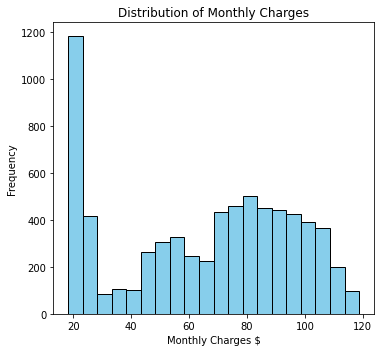

In [15]:
# Plot histograms for monthly_charges and total_charges
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_contract['monthly_charges'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges $')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Monthly charges less than thirty dollars appears to be the most common showing the highest frequency with higher monthly charges of approximately seventy to one hundred being about the same,

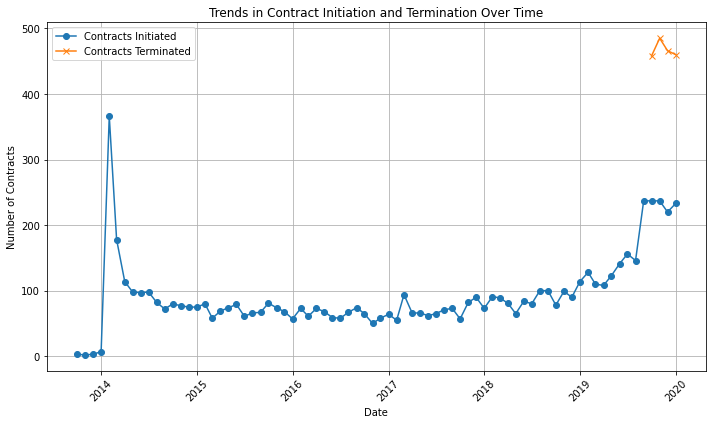

In [16]:
# Convert 'begin_date' and 'end_date' columns to datetime format
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

# Group by 'begin_date' and 'end_date' to count the number of contracts initiated and terminated each month
contracts_initiated = df_contract.groupby(df_contract['begin_date'].dt.to_period('M')).size()
contracts_terminated = df_contract.groupby(df_contract['end_date'].dt.to_period('M')).size()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(contracts_initiated.index.to_timestamp(), contracts_initiated.values, label='Contracts Initiated', marker='o')
plt.plot(contracts_terminated.index.to_timestamp(), contracts_terminated.values, label='Contracts Terminated', marker='x')

plt.title('Trends in Contract Initiation and Termination Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The line plot or time series plot can illustrates trends over time in the initiation and termination of contracts. There was a large spike in initiated contracts in early 2014, then settled to a consistent number of contracts throughout the following years and slowly increased approaching 2020 before a large drop. That large drop in initiated contracts correlates with the same time period that we see a large number of terminated contracts.

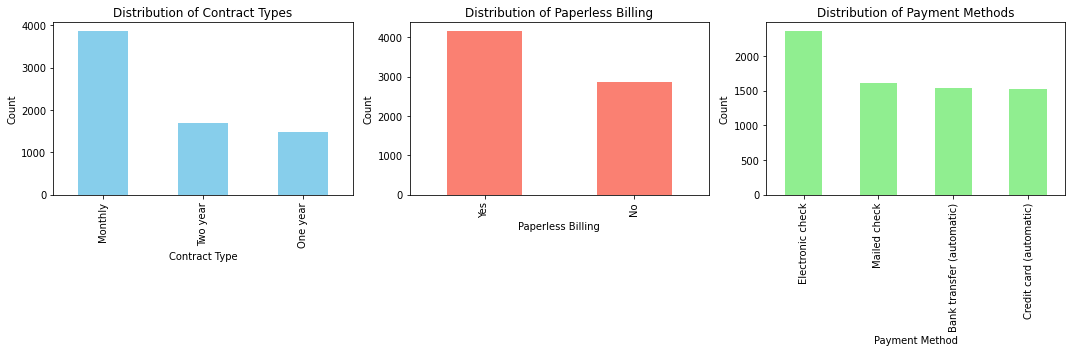

In [17]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot for contract types
plt.subplot(1, 3, 1)
df_contract['type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Contract Types')
plt.xlabel('Contract Type')
plt.ylabel('Count')

# Plot for paperless billing
plt.subplot(1, 3, 2)
df_contract['paperless_billing'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Paperless Billing')
plt.xlabel('Paperless Billing')
plt.ylabel('Count')

# Plot for payment methods
plt.subplot(1, 3, 3)
df_contract['payment_method'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

It appears that approximately half of customers opt for month to month billing instead of one or two year contracts. Paperless billing and utilizing electronic checks for payment is the most common forms of billing and payment.

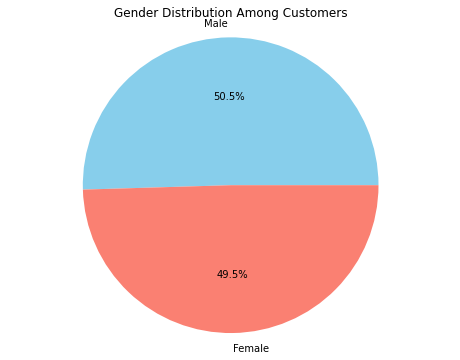

In [18]:
# Count the number of males and females
gender_counts = df_personal['gender'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))

# Create a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'])

# Add a title
plt.title('Gender Distribution Among Customers')

# Display the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

THe distribution between male and female customers appears to be about the same.

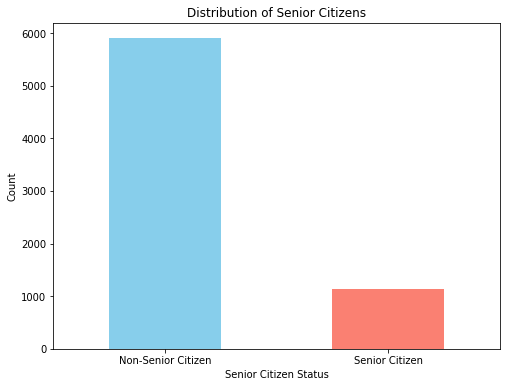

In [19]:
# Count the number of senior citizens and non-senior citizens
senior_counts = df_personal['senior_citizen'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))

# Create a bar plot
senior_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add titles and labels
plt.title('Distribution of Senior Citizens')
plt.xlabel('Senior Citizen Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Senior Citizen', 'Senior Citizen'], rotation=0)

# Display the plot
plt.show()

Most of the clients are non senior-citizens.

# Clarifying Questions <a id='questions'></a>

What specific information about the datasets are we looking to explore during the exploratory data analysis (EDA)?

Are there any particular patterns or trends that the telecom operator is interested in identifying from the data?

Do we have any specific assumptions about the data or the business problem that need to be clarified before conducting the analysis?

Are there any missing values or inconsistencies in the data that need to be addressed during the EDA process?

Are there any specific metrics or key performance indicators (KPIs) that the telecom operator is interested in tracking?

# Plan <a id='plan'></a>

Data Loading and Understanding:
Load each dataset (contract.csv, personal.csv, internet.csv, and phone.csv) into separate pandas DataFrames.
Understand the structure of each dataset, including the number of rows and columns, data types, and any missing values.

Data Cleaning and Preprocessing:
Check for and handle missing or duplicate values in each dataset.
Ensure consistency in column names and data formats across all datasets.
Merge the datasets based on the common column customer_id.

Exploratory Data Analysis (EDA):
Perform univariate analysis on each dataset to understand the distribution of individual variables.
Conduct bivariate analysis to explore relationships between variables, especially with respect to the target variable EndDate.
Visualize key insights using plots such as histograms, box plots, scatter plots, and correlation matrices.

Feature Engineering:
Create new features if necessary based on domain knowledge or insights gained during EDA.
Encode categorical variables and handle any outliers or skewness in the data.

Identifying Churn Predictors:
Use statistical tests or machine learning models to identify key predictors of churn.
Evaluate the importance of features in predicting churn using techniques like feature importance plots or permutation importance.

Conclusion and Recommendations:
Summarize the findings from the EDA and feature engineering stages.
Provide actionable recommendations to the telecom operator based on the insights gained, such as targeting specific customer segments for retention efforts or improving service offerings based on identified trends.

# Modeling <a id='model'></a>

## Prepare Data for Modeling <a id='model_prep'></a> <a class="tocSkip">

In [20]:
# Merge df_contract with df_personal
df_merged = pd.merge(df_contract, df_personal, on='customer_id', how='left')

# Merge df_merged with df_internet
df_merged = pd.merge(df_merged, df_internet, on='customer_id', how='left')

# Merge df_merged with df_phone
df_merged = pd.merge(df_merged, df_phone, on='customer_id', how='left')

# Fill missing values with appropriate placeholders
df_merged.fillna({'gender': 'Unknown',
                  'senior_citizen': -1,
                  'partner': 'Unknown',
                  'dependents': 'Unknown',
                  'internet_service': 'None',
                  'online_security': 'No',
                  'online_backup': 'No',
                  'device_protection': 'No',
                  'tech_support': 'No',
                  'streaming_tv': 'No',
                  'streaming_movies': 'No',
                  'multiple_lines': 'No'}, inplace=True)

# Convert end_date to binary target variable: Churn (1) / No Churn (0)
df_merged['Churn'] = df_merged['end_date'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Calculate duration
df_merged['begin_date'] = pd.to_datetime(df_merged['begin_date'])
df_merged['end_date'] = pd.to_datetime(df_merged['end_date'])
df_merged['duration'] = (df_merged['end_date'] - df_merged['begin_date']).dt.days

# Fill missing values in duration column with -1 (indicating ongoing service)
df_merged['duration'].fillna(-1, inplace=True)

# Display the merged dataframe
df_merged.info()
print()
print(df_merged.isna().sum())
display(df_merged)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,Churn,duration
0,7590-VHVEG,2020-01-01,NaT,Monthly,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,-1.0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,-1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Monthly,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,-1.0
4,9237-HQITU,2019-09-01,2019-11-01,Monthly,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,-1.0
7028,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,-1.0
7029,4801-JZAZL,2019-03-01,NaT,Monthly,Yes,Electronic check,29.60,346.45,Female,0,...,DSL,Yes,No,No,No,No,No,No,0,-1.0
7030,8361-LTMKD,2019-07-01,2019-11-01,Monthly,Yes,Mailed check,74.40,306.60,Male,1,...,Fiber optic,No,No,No,No,No,No,Yes,1,123.0


The column with missing values, end_date, is already accounted for as the client still being active and given the placeholder -1. Feature engineering was used to create the duration column, representing the number of days the churn client was subscribed to the service. The placeholder -1 was used for the active clients. 

## Visualize Data for Modeling <a id='visualize'></a> <a class="tocSkip">

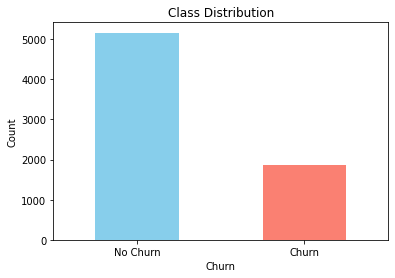

Class Distribution:
0    5163
1    1869
Name: Churn, dtype: int64


In [21]:
# Calculate class distribution
class_distribution = df_merged['Churn'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))

# Create a bar plot
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])

# Add titles and labels
plt.title('Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)

# Display the plot
plt.show()

# Print the class distribution
print("Class Distribution:")
print(class_distribution)

Class 0 represents customers who have not churned. In the dataset, there are 5174 instances of customers who have not churned.
Class 1 represents customers who have churned. In the dataset, there are 1869 instances of customers who have churned.
This distribution indicates that there are significantly more instances of customers who have not churned (5174 instances) compared to those who have churned (1869 instances).

Class imbalance occurs when one class (in this case, customers who have not churned) heavily outweighs the other class (customers who have churned). In this scenario, there is indeed a class imbalance.

It's important to be aware of class imbalances because they can impact the performance of machine learning models, particularly those that are sensitive to class distribution. In cases of significant class imbalance, it may be necessary to employ strategies such as resampling techniques or using appropriate evaluation metrics to handle the imbalance effectively.

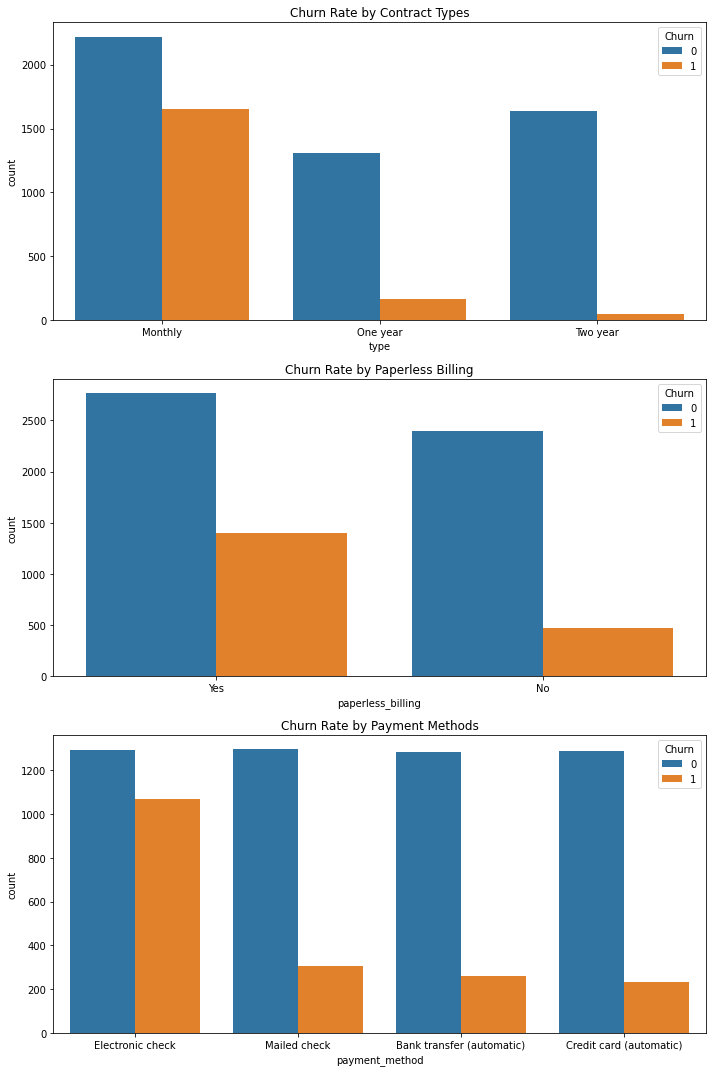

In [22]:
# Set up the subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for contract types
sns.countplot(x='type', hue='Churn', data=df_merged, ax=axes[0])
axes[0].set_title('Churn Rate by Contract Types')

# Plot for paperless billing
sns.countplot(x='paperless_billing', hue='Churn', data=df_merged, ax=axes[1])
axes[1].set_title('Churn Rate by Paperless Billing')

# Plot for payment methods
sns.countplot(x='payment_method', hue='Churn', data=df_merged, ax=axes[2])
axes[2].set_title('Churn Rate by Payment Methods')

plt.tight_layout()
plt.show()

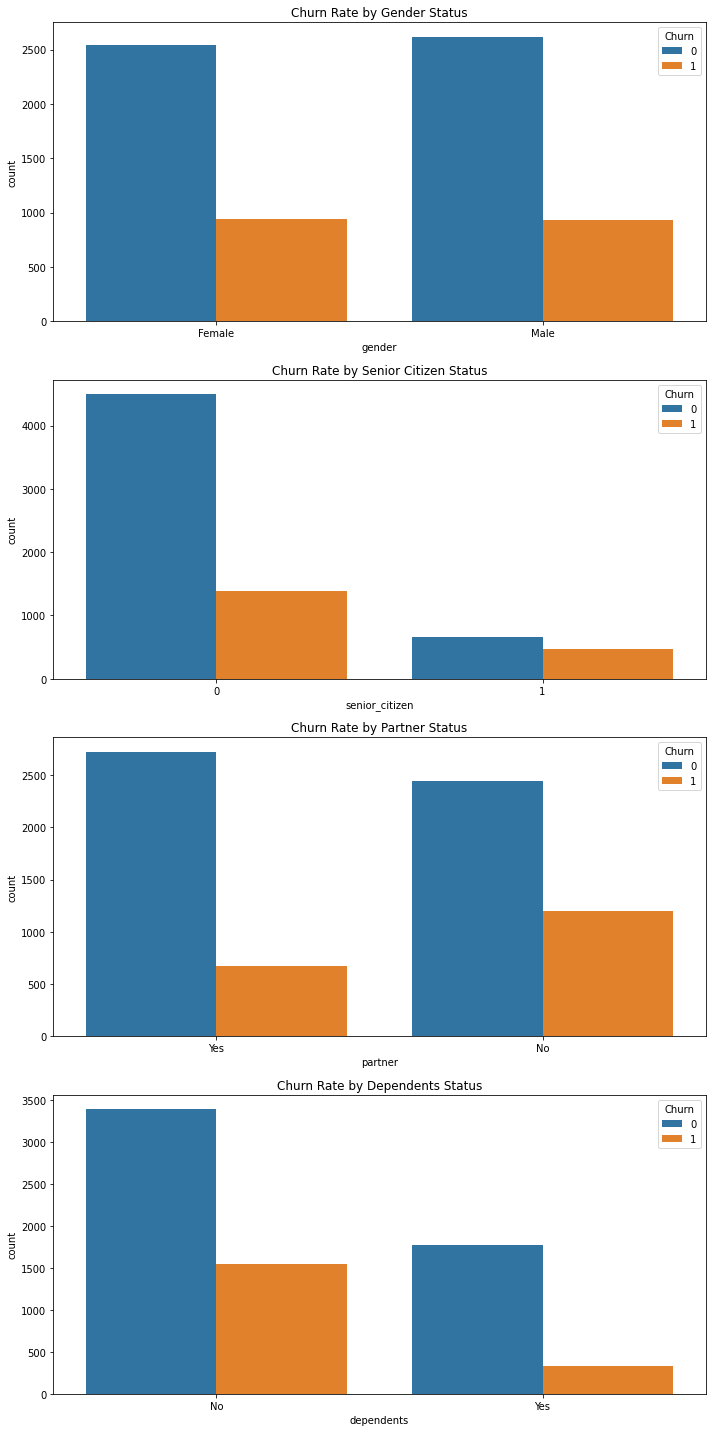

In [23]:
# Set up the subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Gender
sns.countplot(x='gender', hue='Churn', data=df_merged, ax=axes[0])
axes[0].set_title('Churn Rate by Gender Status')

# Senior Citizen
sns.countplot(x='senior_citizen', hue='Churn', data=df_merged, ax=axes[1])
axes[1].set_title('Churn Rate by Senior Citizen Status')

# Partner
sns.countplot(x='partner', hue='Churn', data=df_merged, ax=axes[2])
axes[2].set_title('Churn Rate by Partner Status')

# Dependents
sns.countplot(x='dependents', hue='Churn', data=df_merged, ax=axes[3])
axes[3].set_title('Churn Rate by Dependents Status')

plt.tight_layout()
plt.show()

Based on the above plots comparing various features with churn, all but gender show a difference in churn and will be considered in the model.

## Encode Categorical Features <a id='encode'></a> <a class="tocSkip">

In [24]:
# Drop the specified columns to cleanup for modeling
columns_to_drop = ['customer_id', 'begin_date', 'end_date', 'gender', 'duration']

df_model = df_merged.drop(columns=columns_to_drop)

display(df_model.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,Churn
0,Monthly,Yes,Electronic check,29.85,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,One year,No,Mailed check,56.95,1889.50,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,Monthly,Yes,Mailed check,53.85,108.15,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,Monthly,Yes,Electronic check,70.70,151.65,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


In [25]:
# Address Class Imbalance 
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(drop='first')

# Encode categorical variables and convert to a dense array
X_encoded_array = onehot_encoder.fit_transform(df_model[['type', 'paperless_billing', 'payment_method', 'internet_service']]).toarray()

# Create DataFrame with encoded columns
X_encoded = pd.DataFrame(X_encoded_array, columns=onehot_encoder.get_feature_names_out(['type', 'paperless_billing', 'payment_method', 'internet_service']))

# Drop original categorical columns from df_model
X.drop(['type', 'paperless_billing', 'payment_method', 'internet_service'], axis=1, inplace=True)

# Concatenate the encoded columns with the original dataframe
X = pd.concat([X, X_encoded], axis=1)

# Ensure the indices are aligned
X.reset_index(drop=True, inplace=True)

In [26]:
# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode columns containing 'yes' and 'no' using ordinal encoding
X[['partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines' ]] = ordinal_encoder.fit_transform(X[['partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']])

In [27]:
# Confirm appearance of data frame for modeling
X.info()
display(X.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         7032 non-null   float64
 1   total_charges                           7032 non-null   float64
 2   senior_citizen                          7032 non-null   int64  
 3   partner                                 7032 non-null   float64
 4   dependents                              7032 non-null   float64
 5   online_security                         7032 non-null   float64
 6   online_backup                           7032 non-null   float64
 7   device_protection                       7032 non-null   float64
 8   tech_support                            7032 non-null   float64
 9   streaming_tv                            7032 non-null   float64
 10  streaming_movies                        7032 non-null   floa

,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_None
0,29.85,29.85,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,56.95,1889.50,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,53.85,108.15,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,42.30,1840.75,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70.70,151.65,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Model <a id='model'></a> <a class="tocSkip">

### Random Forest Model <a id='random_forest'></a> <a class="tocSkip">

In [28]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Define the pipeline for Random Forest with SMOTE
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for Random Forest
params_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Perform cross-validation with StratifiedKFold and GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=params_rf, scoring='roc_auc', cv=skf)
grid_search_rf.fit(X, y)

# Model Evaluation
y_test_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
print("Accuracy on test set for Random Forest:", accuracy_test_rf)

y_test_pred_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
auc_roc_test_rf = roc_auc_score(y_test, y_test_pred_rf)
print("AUC-ROC on test set for Random Forest:", auc_roc_test_rf)

# Check if the final model meets the AUC-ROC threshold and accuracy metric
if auc_roc_test_rf >= 0.75:
    print("Final Random Forest model meets the performance requirement.")
else:
    print("Final Random Forest model does not meet the performance requirement.")

Accuracy on test set for Random Forest: 0.8137882018479033
AUC-ROC on test set for Random Forest: 0.8801942320534656
Final Random Forest model meets the performance requirement.


The Random Forest model achieved an Accuracy of 81.38%. This means that the model correctly predicts whether a customer churned or not around 81.38% of the time. 

The AUC-ROC obtained was 0.8802. The Area Under the Receiver Operating Characteristic Curve (AUC-ROC) measures the model's ability to distinguish between classes. An AUC-ROC value closer to 1 indicates better performance. In this case, an AUC-ROC of 0.8802 suggests that the Random Forest model performs reasonably well in distinguishing between churn and non-churn customers.

Overall, these results indicate that the Random Forest model performs decently in predicting customer churn, with both accuracy and AUC-ROC metrics showing satisfactory performance.

While the model meets the required performance level to obtain 6 Story Points, other models will still be reviewed.

### Gradient Boosting Model <a id='gradient_boosting'></a> <a class="tocSkip">

In [30]:
# Define the pipeline for Gradient Boosting with SMOTE
gb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for Gradient Boosting
params_gb = {
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__n_estimators': [100, 200, 300],
    'gb__max_depth': [3, 4, 5],
    'gb__min_samples_leaf': [1, 2, 4]
}

# Perform cross-validation with StratifiedKFold and GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb_pipeline, param_grid=params_gb, scoring='roc_auc', cv=skf)
grid_search_gb.fit(X, y)

# Model Evaluation
y_test_pred_gb = grid_search_gb.best_estimator_.predict(X_test)
accuracy_test_gb = accuracy_score(y_test, y_test_pred_gb)
print("Accuracy on test set for Gradient Boosting:", accuracy_test_gb)

y_test_pred_gb = grid_search_gb.best_estimator_.predict_proba(X_test)[:, 1]
auc_roc_test_gb = roc_auc_score(y_test, y_test_pred_gb)
print("AUC-ROC on test set for Gradient Boosting:", auc_roc_test_gb)

# Check if the final model meets the AUC-ROC threshold and accuracy metric
if auc_roc_test_gb >= 0.75:
    print("Final Gradient Boosting model meets the performance requirement.")
else:
    print("Final Gradient Boosting model does not meet the performance requirement.")

Accuracy on test set for Gradient Boosting: 0.8045486851457001
AUC-ROC on test set for Gradient Boosting: 0.8497445268699754
Final Gradient Boosting model meets the performance requirement.


For the Gradient Boosting model achieved an Accuracy of 80.45%. This means that the model correctly predicts whether a customer churned or not approximately 80.45% of the time.

The AUC-ROC value obtained was 0.8497, which meets the criteria of having 4 Story Points. This model performs reasonably well in distinguishing between the two classes. The Gradient Boosting model demonstrates decent performance in predicting customer churn, with both accuracy and AUC-ROC metrics showing satisfactory results, albeit slightly lower than those of the Random 
Forest model.

The run time for the Gradient Boosting model was also significantly longer than that of the Random Forest model. This, in combination with the better AUC-ROC value from the Random Forest model indicate, that the Random Forest model should be considered as the final model.

# Conclusion <a id='conclusion'></a>

Exploratory data analysis was done for the individual datasets as well as on the merged dataset to understand potential trends when comparing different features with each other and the target. All categorical features were encoded, but feature engineering was not done since the models and hyperparameters used were able to achieve an appropriate accuracy and AUC-ROC score without needing additional features for improvement.

Difficulties encountered during the process was understanding which features actually had an impact on the churn. This was solved by plotting the different features with the churn rate. Those features that showed a significant difference were deemed important in considering churn and kept in the dataset. Those that showed no difference were dropped to maintain only the necessary data.

After trying a few different models and hyperparameter tuning, the final model was the Random Forest Model, which had an accuracy score of 81.38% and an AUC-ROC value of 0.8802, sufficient to attain 6 story points. An AUC-ROC value closer to 1 indicates better performance. In this case, an AUC-ROC of 0.8802 suggests that the Random Forest model performs reasonably well in distinguishing between churn and non-churn customers and the model correctly predicts whether a customer churned or not around 81.38% of the time.

This final model would be beneficial for Telecom because if it can predict which clients will churn, Telecom can then determine the clients that it should send promotional offers to prevent the client from leaving to minimize loss of profit.